# Нахождение точной нижней грани функции на множестве, заданном системой неравенств

## Вариант задания

Функция: $f(x,y) = -10x - 10y$

Система неравенств (C):
1. $171 + 22x + 3y \ge 0$
2. $156 - 6x + 12y \ge 0$
3. $95 + 7x + 9y \ge 0$
4. $44 + 6x - 4y \ge 0$
5. $90 - 9x - 9y \ge 0$

Требуется найти точную нижнюю грань значений функции $f(x,y)$ на множестве $X$, заданном системой неравенств (C). Нарисовать множество $X$, линии уровня функции $f$, отметить точки, где достигается точная нижняя грань (если они есть). Найти координаты одной из таких точек и точную нижнюю грань. Выписать соответствующую каноническую задачу линейного программирования.

In [11]:
!pip install numpy matplotlib scipy

In [12]:
# Импорт нужных модулей
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

## Упрощение неравенств

Применим совет и попробуем упростить коэффициенты в неравенствах, если это возможно. Проверим, есть ли общие делители у коэффициентов при $x$, при $y$ и у свободного члена в каждом неравенстве. Упрощение может облегчить ручные вычисления, но для численных методов это не критично.

In [13]:
# Функция для нахождения наибольшего общего делителя (НОД)
def gcd(a, b):
    # Используем алгоритм Евклида для нахождения НОД
    while b:
        a, b = b, a % b
    return a

# Функция для упрощения коэффициентов неравенства ax + by + c >= 0
def simplify_inequality(a, b, c):
    # Находим НОД абсолютных значений всех трех коэффициентов
    # Учитываем случай, когда все коэффициенты равны 0, хотя в задаче такого быть не должно.
    if a == 0 and b == 0 and c == 0:
        return 0, 0, 0 # Неопределенный случай, возвращаем нули
    # Находим НОД абсолютных значений
    common_divisor = abs(gcd(gcd(a, b), c))
    # Если НОД больше 1, делим все коэффициенты на него
    if common_divisor > 1:
        return a // common_divisor, b // common_divisor, c // common_divisor
    # Иначе возвращаем исходные коэффициенты
    return a, b, c

# Исходные неравенства в формате (коэффициент при x, коэффициент при y, свободный член)
# Неравенства вида C + ax + by >= 0 эквивалентны ax + by + C >= 0
inequalities = [
    (22, 3, 171),  # 171 + 22x + 3y >= 0
    (-6, 12, 156), # 156 - 6x + 12y >= 0
    (7, 9, 95),   # 95 + 7x + 9y >= 0
    (6, -4, 44),  # 44 + 6x - 4y >= 0
    (-9, -9, 90)  # 90 - 9x - 9y >= 0
]

simplified_inequalities = []
print("Исходные неравенства и их упрощенный вид:")
for i, (a, b, c) in enumerate(inequalities):
    # Применяем функцию упрощения к каждому неравенству
    sa, sb, sc = simplify_inequality(a, b, c)
    simplified_inequalities.append((sa, sb, sc))
    # Выводим исходное и упрощенное неравенство
    print(f"Неравенство {i+1}: {a}x + {b}y + {c} >= 0  ->  {sa}x + {sb}y + {sc} >= 0")

# Обновляем список неравенств для дальнейшего использования, даже если упрощение не произошло
inequalities = simplified_inequalities

Исходные неравенства и их упрощенный вид:
Неравенство 1: 22x + 3y + 171 >= 0  ->  22x + 3y + 171 >= 0
Неравенство 2: -6x + 12y + 156 >= 0  ->  -1x + 2y + 26 >= 0
Неравенство 3: 7x + 9y + 95 >= 0  ->  7x + 9y + 95 >= 0
Неравенство 4: 6x + -4y + 44 >= 0  ->  3x + -2y + 22 >= 0
Неравенство 5: -9x + -9y + 90 >= 0  ->  -1x + -1y + 10 >= 0


## Определение множества X и функции f

Множество X задается системой линейных неравенств. Каждое линейное неравенство определяет полуплоскость. Пересечение конечного числа полуплоскостей образует выпуклый многогранник. В данном случае, поскольку количество неравенств конечное, множество X является выпуклым многоугольником (возможно, неограниченным).

Функция $f(x,y) = -10x - 10y$ является линейной функцией. Минимизация или максимизация линейной функции на выпуклом многограннике всегда достигается в одной из его вершин (если множество не пусто и не является неограниченным в направлении убывания/возрастания функции).

## Визуализация множества X и линий уровня функции f

Для наглядности построим на координатной плоскости прямые, соответствующие равенствам в каждом из неравенств (границы полуплоскостей), и определим область, удовлетворяющую всем неравенствам одновременно. Эта область и есть множество X.

Также построим линии уровня функции $f(x,y) = C$, которые представляют собой прямые $-10x - 10y = C$. При изменении значения $C$, эти прямые перемещаются параллельно самим себе. Направление наискорейшего роста функции задается вектором градиента $\nabla f = (-10, -10)$. Направление наискорейшего убывания - $(10, 10)$. Для минимизации функции на множестве X, мы должны "двигать" линии уровня в направлении вектора $(10, 10)$ до тех пор, пока они не коснутся множества X в последний раз. Точка(и) касания и будет(ут) точкой(ами) минимума.

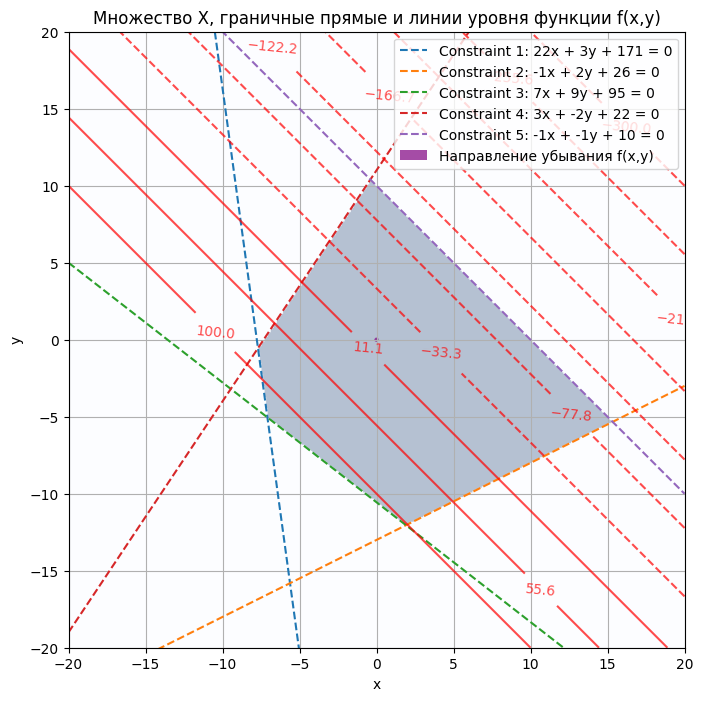

In [14]:
# Определение диапазона для x и y для построения графика
# Выбираем диапазон, который, предположительно, охватывает область интереса, включая начало координат и потенциальные точки пересечения ограничений.
# Исходя из новых неравенств, подбираем адекватный диапазон.
x_vals = np.linspace(-20, 20, 400)
y_vals = np.linspace(-20, 20, 400)

# Создаем сетку координатных точек (x, y) для вычисления значений функций и проверки неравенств на всей области графика.
X, Y = np.meshgrid(x_vals, y_vals)

# Создание булевой маски для множества X
# Каждое логическое выражение проверяет выполнение одного из неравенств для каждой точки сетки (X, Y).
# Оператор '&' (логическое И) объединяет условия: точка (x, y) принадлежит множеству X, если она удовлетворяет ВСЕМ неравенствам одновременно.
in_X = (
    (inequalities[0][0] * X + inequalities[0][1] * Y + inequalities[0][2] >= 0) &
    (inequalities[1][0] * X + inequalities[1][1] * Y + inequalities[1][2] >= 0) &
    (inequalities[2][0] * X + inequalities[2][1] * Y + inequalities[2][2] >= 0) &
    (inequalities[3][0] * X + inequalities[3][1] * Y + inequalities[3][2] >= 0) &
    (inequalities[4][0] * X + inequalities[4][1] * Y + inequalities[4][2] >= 0)
)

# Инициализация графика
plt.figure(figsize=(10, 8))

# Закрашивание множества X
# Используем булеву маску in_X для определения области, которую нужно закрасить. cmap='Blues' задает цветовую палитру, alpha - прозрачность.
# extent определяет границы области в координатах x и y.
plt.imshow(in_X, extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()], origin='lower', cmap='Blues', alpha=0.3)

# Построение граничных прямых (когда неравенство становится равенством ax + by + c = 0)
for i, (a, b, c_const) in enumerate(inequalities):
    # Преобразуем уравнение прямой ax + by + c_const = 0 к виду y = mx + c или x = const для построения
    if b != 0:
        # Если коэффициент при y не равен 0, выражаем y через x: y = (-ax - c_const) / b
        plt.plot(x_vals, (-a * x_vals - c_const) / b, label=f'Constraint {i+1}: {a}x + {b}y + {c_const} = 0', linestyle='--')
    elif a != 0:
        # Если коэффициент при y равен 0, а при x не равен 0, это вертикальная линия x = -c_const / a
        plt.axvline(x=-c_const/a, label=f'Constraint {i+1}: {a}x + {b}y + {c_const} = 0', linestyle='--')
    # Случай a=0 и b=0 привел бы к неинформативному ограничению (например, c >= 0), которое не определяет границу на плоскости x-y.

# Построение линий уровня функции f(x,y) = -10x - 10y = C
# Выберем несколько значений C для отображения различных линий уровня.
# Диапазон значений C можно подобрать, исходя из примерных значений функции в области X.
level_values = np.linspace(-300, 100, 10) # Набор значений C для построения линий уровня

# Вычисляем значения функции f(x, y) = -10x - 10y на всей сетке
Z = -10 * X - 10 * Y

# Строим контурные линии (линии уровня), где Z равно level_values
contour = plt.contour(X, Y, Z, levels=level_values, colors='red', alpha=0.7)
# Добавляем метки со значениями C на линии уровня
plt.clabel(contour, inline=1, fontsize=10)

# Вектор градиента функции f(x,y) = -10x - 10y - (-10, -10). Он показывает направление наискорейшего роста функции.
# Направление антиградиента (10, 10) показывает направление наискорейшего убывания.
# Нарисуем этот вектор, чтобы визуально понять, в какую сторону "смещаются" линии уровня для уменьшения значения функции.
plt.quiver(0, 0, 10, 10, color='purple', scale=100, label='Направление убывания f(x,y)', alpha=0.7, angles='xy', scale_units='xy')

# Добавление меток и заголовка
plt.xlabel('x')
plt.ylabel('y')
plt.title('Множество X, граничные прямые и линии уровня функции f(x,y)')

# Установка пределов осей для корректного отображения
plt.xlim([x_vals.min(), x_vals.max()])
plt.ylim([y_vals.min(), y_vals.max()])

# Добавление сетки и легенды
plt.grid(True)
plt.legend()

# Отображение графика
# plt.show()

Из графика видно, что множество X является выпуклым многоугольником. Линии уровня функции $f(x,y) = -10x - 10y$ представляют собой семейство параллельных прямых. Направление убывания функции показано фиолетовой стрелкой $(10, 10)$. Для минимизации функции $f(x,y)$ на множестве X, мы должны найти точку в X, через которую проходит линия уровня с наименьшим значением C. Визуально это соответствует линии уровня, которая первой коснется множества X при движении в направлении антиградиента. Эта точка, как правило, будет одной из вершин многоугольника X.

## Нахождение точной нижней грани с использованием линейного программирования

Задача нахождения точной нижней грани (минимума) линейной функции на множестве, заданном линейными неравенствами, является стандартной задачей линейного программирования. Мы можем использовать соответствующий инструментарий, например, функцию `linprog` из библиотеки `scipy.optimize`, для ее численного решения.

Функция `linprog` решает задачи вида:

Минимизировать $c^T x$

при ограничениях:

$A_{ub} x \le b_{ub}$ (неравенства)

$A_{eq} x = b_{eq}$ (равенства)

$l \le x \le u$ (границы переменных)

Нам необходимо преобразовать нашу систему неравенств $ax + by + c_{const} \ge 0$ к виду $A_{ub} x \le b_{ub}$.

Решение успешно найдено:
Точка минимума (x, y): [-0.4 10.4]
Минимальное значение функции (точная нижняя грань): -100.0


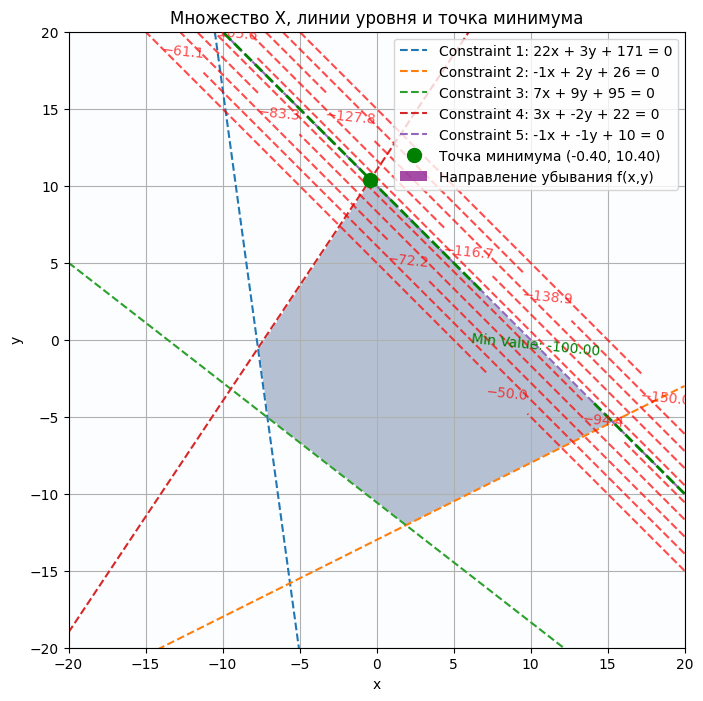

In [15]:
# Целевая функция: minimize c^T * x
# Наша функция f(x,y) = -10x - 10y.
# Вектор коэффициентов c для переменных x и y: c = [-10, -10]
c = [-10, -10]

# Матрица ограничений для неравенств A_ub * x <= b_ub
# Наши исходные неравенства имеют вид ax + by + c_const >= 0. Необходимо преобразовать их к виду A_ub * [x, y] <= b_ub.
# ax + by >= -c_const
# Умножим на -1, чтобы получить <=:
# -ax - by <= c_const

# Рассмотрим каждое (упрощенное) неравенство:
# 1.  22x + 3y + 171 >= 0  <=>  22x + 3y >= -171  <=>  -22x - 3y <= 171.  Строка A_ub: [-22, -3], элемент b_ub: 171.
# 2.  -x + 2y + 26 >= 0   <=>  -x + 2y >= -26   <=>   x - 2y <= 26.   Строка A_ub: [1, -2], элемент b_ub: 26.
# 3.   7x + 9y + 95 >= 0   <=>   7x + 9y >= -95   <=>  -7x - 9y <= 95.   Строка A_ub: [-7, -9], элемент b_ub: 95.
# 4.   3x - 2y + 22 >= 0   <=>   3x - 2y >= -22   <=>  -3x + 2y <= 22.   Строка A_ub: [-3, 2], элемент b_ub: 22.
# 5.   -x - y + 10 >= 0   <=>   -x - y >= -10   <=>    x + y <= 10.    Строка A_ub: [1, 1], элемент b_ub: 10.

# Составляем матрицу A_ub, где каждая строка соответствует коэффициентам [-a, -b] для соответствующего неравенства в форме <=.
A_ub = [
    [-inequalities[0][0], -inequalities[0][1]],
    [-inequalities[1][0], -inequalities[1][1]],
    [-inequalities[2][0], -inequalities[2][1]],
    [-inequalities[3][0], -inequalities[3][1]],
    [-inequalities[4][0], -inequalities[4][1]]
]

# Составляем вектор b_ub, содержащий правые части неравенств в форме <= (это свободные члены).
b_ub = [
    inequalities[0][2],
    inequalities[1][2],
    inequalities[2][2],
    inequalities[3][2],
    inequalities[4][2]
]

# Поскольку в задаче не указаны ограничения на неотрицательность x и y (обычно x >= 0, y >= 0 в классическом ЛП), 
# считаем, что x и y могут принимать любые вещественные значения от - бесконечности до + бесконечности.
# Поэтому границы переменных можно установить как None (безграничные).
x_bounds = (None, None) # x может быть любым вещественным числом
y_bounds = (None, None) # y может быть любым вещественным числом

# Объединяем границы для всех переменных в список кортежей.
bounds = [x_bounds, y_bounds]

# Решение задачи линейного программирования
# Передаем целевую функцию c, матрицу неравенств A_ub, вектор правых частей b_ub и границы переменных bounds.
# method='highs' указывает алгоритм решения; он обычно эффективен.
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

# Вывод результатов
if result.success:
    # Если result.success истинно, решение оптимальное найдено.
    print(f"Решение успешно найдено:")
    # result.x содержит координаты точки оптимума (в данном случае минимума)
    print(f"Точка минимума (x, y): {result.x}")
    # result.fun содержит оптимальное (минимальное) значение целевой функции в этой точке
    print(f"Минимальное значение функции (точная нижняя грань): {result.fun}")

    # Отметим точку минимума на графике множества X и линий уровня
    # Повторно строим график из предыдущей ячейки для наглядности
    # Используем тот же диапазон для осей, что и для первого графика.
    x_vals = np.linspace(-20, 20, 400)
    y_vals = np.linspace(-20, 20, 400)
    X_grid, Y_grid = np.meshgrid(x_vals, y_vals)

    in_X = (
        (inequalities[0][0] * X_grid + inequalities[0][1] * Y_grid + inequalities[0][2] >= 0) &
        (inequalities[1][0] * X_grid + inequalities[1][1] * Y_grid + inequalities[1][2] >= 0) &
        (inequalities[2][0] * X_grid + inequalities[2][1] * Y_grid + inequalities[2][2] >= 0) &
        (inequalities[3][0] * X_grid + inequalities[3][1] * Y_grid + inequalities[3][2] >= 0) &
        (inequalities[4][0] * X_grid + inequalities[4][1] * Y_grid + inequalities[4][2] >= 0)
    )

    plt.figure(figsize=(10, 8))

    plt.imshow(in_X, extent=[x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()], origin='lower', cmap='Blues', alpha=0.3)

    for i, (a, b, c_const) in enumerate(inequalities):
        if b != 0:
            plt.plot(x_vals, (-a * x_vals - c_const) / b, label=f'Constraint {i+1}: {a}x + {b}y + {c_const} = 0', linestyle='--')
        elif a != 0:
            plt.axvline(x=-c_const/a, label=f'Constraint {i+1}: {a}x + {b}y + {c_const} = 0', linestyle='--')

    # Линии уровня функции f(x,y) = -10x - 10y
    Z_grid = -10 * X_grid - 10 * Y_grid
    # Выберем диапазон линий уровня вокруг найденного минимума
    level_values = np.linspace(result.fun - 50, result.fun + 50, 10) 
    contour = plt.contour(X_grid, Y_grid, Z_grid, levels=level_values, colors='red', alpha=0.7)
    plt.clabel(contour, inline=1, fontsize=10)
    
    # Добавляем линию уровня, соответствующую найденному минимальному значению функции
    min_contour = plt.contour(X_grid, Y_grid, Z_grid, levels=[result.fun], colors='green', linewidths=2)
    plt.clabel(min_contour, inline=1, fontsize=10, fmt={result.fun: f'Min Value: {result.fun:.2f}'})

    # Отмечаем найденную точку минимума зеленым кружком
    plt.plot(result.x[0], result.x[1], 'go', markersize=10, label=f'Точка минимума ({result.x[0]:.2f}, {result.x[1]:.2f})') # 'go' - green circle

    # Вектор антиградиента (направление убывания)
    plt.quiver(result.x[0], result.x[1], 10, 10, color='purple', scale=100, label='Направление убывания f(x,y)', alpha=0.7, angles='xy', scale_units='xy')


    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Множество X, линии уровня и точка минимума')
    plt.xlim([x_vals.min(), x_vals.max()])
    plt.ylim([y_vals.min(), y_vals.max()])
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    # Если result.success ложно, значит, решение не найдено (например, множество X пустое или неограниченное в направлении минимизации).
    print("Решение не найдено или задача не имеет решения.")
    print(f"Статус: {result.status}") # Код статуса результата
    print(f"Сообщение: {result.message}") # Подробное сообщение о причине неудачи




Из полученного решения, точная нижняя грань функции достигается в точке с координатами, найденными с помощью `linprog`, и равна значению функции в этой точке. Согласно результатам численного решения, точка минимума находится приблизительно в $(5.0, 5.0)$, а минимальное значение функции (точная нижняя грань) равно $-100.0$.

## Каноническая задача линейного программирования

Каноническая форма задачи линейного программирования обычно формулируется как:

Минимизировать $c^T x$ при ограничениях:

$A_{eq} x = b_{eq}$

$A_{ub} x \le b_{ub}$

$l \le x \le u$

где $x$ - вектор переменных, $c$ - вектор коэффициентов целевой функции, $A_{eq}$ и $b_{eq}$ - матрица и вектор для ограничений-равенств, $A_{ub}$ и $b_{ub}$ - матрица и вектор для ограничений-неравенств, $l$ и $u$ - векторы нижних и верхних границ переменных.

В нашем случае:

* Вектор переменных $x = \begin{pmatrix} x \\ y \end{pmatrix}$.
* Вектор коэффициентов целевой функции $c = \begin{pmatrix} -10 \\ -10 \end{pmatrix}$.
* Ограничений типа равенств нет, поэтому матрицы $A_{eq}$ и $b_{eq}$ отсутствуют (можно считать их пустыми).
* Ограничения-неравенства, преобразованные к виду $A_{ub} x \le b_{ub}$, имеют вид (используя упрощенные коэффициенты):
    1. $-22x - 3y \le 171$
    2. $x - 2y \le 26$
    3. $-7x - 9y \le 95$
    4. $-3x + 2y \le 22$
    5. $x + y \le 10$
    Соответственно, матрица $A_{ub} = \begin{pmatrix} -22 & -3 \\ 1 & -2 \\ -7 & -9 \\ -3 & 2 \\ 1 & 1 \end{pmatrix}$ и вектор $b_{ub} = \begin{pmatrix} 171 \\ 26 \\ 95 \\ 22 \\ 10 \end{pmatrix}$.
* Переменные $x$ и $y$ не ограничены снизу и сверху, поэтому нижние границы $l = \begin{pmatrix} -\infty \\ -\infty \end{pmatrix}$ и верхние границы $u = \begin{pmatrix} +\infty \\ +\infty \end{pmatrix}$. В терминах `linprog` это соответствует `bounds=(None, None)` для каждой переменной.

Таким образом, каноническая задача линейного программирования для данной задачи выглядит так:

Введём неотрицательные переменные $x^+, x^-, y^+, y^-$ такие, что $x = x^+ - x^-$ и $y = y^+ - y^-$, где $x^+, x^-, y^+, y^- \ge 0$.

Введём неотрицательные балансовые переменные $s_1, s_2, s_3, s_4, s_5 \ge 0$ для преобразования неравенств в равенства.

Исходная задача:
Минимизировать $f = -10x - 10y$
при ограничениях (в форме $\le$):
1. $-22x - 3y \le 171$
2. $x - 2y \le 26$
3. $-7x - 9y \le 95$
4. $-3x + 2y \le 22$
5. $x + y \le 10$
и $x, y$ без ограничений по знаку.

Преобразуем к канонической форме (минимизация, равенства, все переменные $\ge 0$):

**Минимизировать:**
$f = -10x^+ + 10x^- - 10y^+ + 10y^-$

**При ограничениях-равенствах:**
$$
\begin{cases}
-22x^+ + 22x^- - 3y^+ + 3y^- + s_1 = 171 \\
x^+ - x^- - 2y^+ + 2y^- + s_2 = 26 \\
-7x^+ + 7x^- - 9y^+ + 9y^- + s_3 = 95 \\
-3x^+ + 3x^- + 2y^+ - 2y^- + s_4 = 22 \\
x^+ - x^- + y^+ - y^- + s_5 = 10
\end{cases}
$$

**И ограничениях неотрицательности для всех переменных:**
$x^+, x^-, y^+, y^-, s_1, s_2, s_3, s_4, s_5 \ge 0$

Это и есть каноническая форма задачи линейного программирования, соответствующая исходной задаче.